## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]) - ca.if_else(t>84, p[3]*y[0], 0, True),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 1
clip = None
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

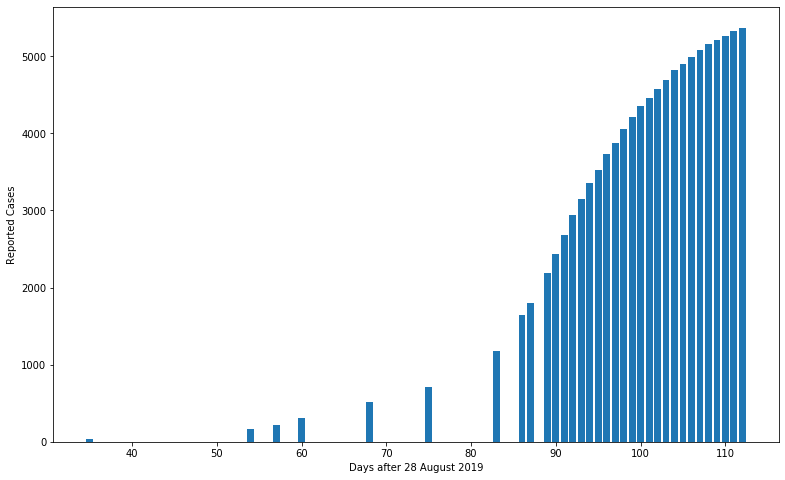

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

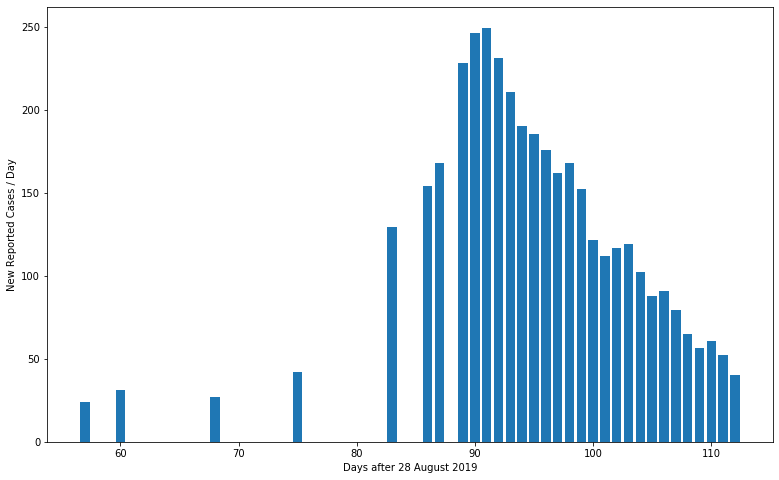

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8, 0]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 4
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

NotImplementedError: Wrong number or type of arguments for overloaded function 'if_else'.
  Possible prototypes are:
    if_else(DM,DM,DM,bool)
    if_else(SX,SX,SX,bool)
    if_else(MX,MX,MX,bool)
  You have: '(MX,SX,int,bool)'


In [ ]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [ ]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [ ]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)

In [ ]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [ ]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [ ]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

In [ ]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

In [ ]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

In [ ]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

In [ ]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

In [ ]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [ ]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

In [ ]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [ ]:
rinf(sols[idx])

In [ ]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [ ]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

In [ ]:
getx(sols[idx]['x'])[0][0]

In [ ]:
getp(sols[idx]['x'])

In [ ]:
r0(sols[idx])

In [ ]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

In [ ]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

In [ ]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('gnuplot')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[40:-15:]):
    plt.plot(model.observation_times, getx(sols[i+40]['x'])[-1], color='k', alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [ ]:
fsvals[idx]

In [ ]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

In [ ]:
getp(sols[idx]['x'])

In [ ]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [ ]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

In [ ]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

In [ ]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [ ]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

In [ ]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

In [ ]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [ ]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

In [ ]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [ ]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

In [ ]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [ ]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

In [ ]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [ ]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [ ]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

In [ ]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

In [ ]:
plt.plot(sol.t, sol.y[:,:].T)

In [ ]:
plt.plot(solb.t, solb.y.T)

In [ ]:
model.observation_times[-1]

In [ ]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [ ]:
rfin = sol.sol(tfine)[-1,-1]
rfin

In [ ]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [ ]:
tfine[ridx]

In [ ]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

In [ ]:
model.observation_times[-1]-model.observation_times[tidx]

In [ ]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

In [ ]:
rfin*historical_mortality

In [ ]:
rfin*current_mortality

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, np.gradient(getx(sols[i]['x'])[4].toarray().flatten(), model.observation_times),
            color=scalarMap.to_rgba(np.log10(p)), alpha=0.3)
plt.plot(times, np.gradient(cumdata, times), 'ro')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)